# Fuzzing basics
## Introduction

(Note, this is made to work on windows, using `wsl`)

At its most basic form, fuzzing refers to feeding a string of **random characters** into a program, aiming to uncover vulnerabilities.

The history of fuzzing comes from an assignment given by a professor to his students, in 1988. They were supposed to come up with a way of generating unpredictable character streams and, using them, test various UNIX utility functions.

Let's take a look into their inner workings. First we will import necessary modules:

In [6]:
import random
from typing import Optional, Any, List, Tuple
from typing import Union, Callable
import time
from types import FrameType, TracebackType
import sys
import traceback
import matplotlib.pyplot as plt
import subprocess
from subprocess import CompletedProcess

First we will provide the basic implementation of a fuzzer:

In [62]:
def fuzzer(max_length: int = 100, char_start: int = 32, char_range: int = 32) -> str:
    """A string of up to `max_length` characters
       in the range [`char_start`, `char_start` + `char_range`)"""
    
    # generate a random string length for our output
    string_length = random.randrange(0, max_length + 1)
    
    out = ""
    for i in range(0, string_length):
        # random.randrange(start, end) returns a random number in [start,end)
        # chr(n) returns the character with ASCII code n -> note that we will also get non-alphanumerical characters
        out += chr(random.randrange(char_start, char_start + char_range))
    return out

Given its random nature, it can be seen that each run gives a different output:

In [63]:
fuzzer()

'5?5*.+17%;/(""1?\'8!-$)4#;()0/>5*8<:< :."<8//$3/7!:% 2+'

The method's parameters can be tweaked, for different behaviours. Let's look at how we can approach the following scenarios:
- only lower case letters
- arbitrary long decimal numbers

In [64]:
# ord(c) returns the ASCII code of character c
print(fuzzer(1000, ord('a'), 26))
print("__________")
print(fuzzer(100, ord('0'), 10))

gaoyjewvrsloyivcxvawmlzvizktwowjmpnldnzcizxieihsxsuulayukzrskilrrxeivowabwepbwwgtmsxdxtkmgiggfhngsfqqhofibpbfkqafhjxkhcfrsvxnmvnauzpqjeudpdklfvozzczkfltfeypdwluuggeqebavmgdcncjdurqgdrwouthfqsdkotscvbuyywiqhgjvjvkbwvenybztllhfhaobwcwcadqeiwtxqzrvcmxymdwqpxpzukjtskagnsjrwikncyicwahtlsqomfkmohoskxcngomopedoenbvxynwglizzwxhhqnfinbcdpvyesbaicpnqeqqbcefhpqhsvwmrcrbdqovxzplvtoowhfvnfvhifqieilsitckrtpyqlgnuleu
__________
24391452067448026597506963120961491787173554797257923687849218149835509492404791


## Fuzzing an external program
Using the `subprocess` module, we can also test external programs with our generated input.
- Note that this notebook was generated on Windows, thus running bash / unix commands requires first installing `Windows Subsystem for Linux`. Such commands should thus being with `wsl`. In case the command `bc` is not installed, one fix would be to enter `wsl` in CMD, then install `bc` with `sudo apt install bc`.

We will be using the `bc` command, which takes as input various formats of operations:
-   Input : `echo "12+5" | bc`
    Output : 17
-   Input: `echo "var=10;var^=2;var" | bc`
    Output: 100
-   Input: `echo 'n=8;m=10;if(n>m) print "n is greater" else print "m is greater" ' | bc -l`
    Output: m is greater

In [65]:


input_content = 'n=8;m=10;if(n>m) print "n is greater" else print "m is greater" '

# in this configuration, input requires a byte format (with a new line appended, since bc  )
result = subprocess.run("wsl bc", input=(input_content+"\n").encode(), capture_output=True)

print(result.stdout.decode("utf-8"))
print(result.stderr.decode("utf-8"))

m is greater


Let's now test how the program behaves when testing it with some random input.

In [36]:


trials = 100
program = "bc"
runs = []
for i in range(trials):
    data = fuzzer()
    result = subprocess.run("wsl " + program, input=(data+"\n").encode(), capture_output=True)
    # decode the stdout and stderr for easier handling
    runs.append((data, 
                 CompletedProcess(
                     result.args,
                     result.returncode, 
                     result.stdout.decode("utf-8"),
                     result.stderr.decode("utf-8"))))


Let's check how many of these runs did not actually run into errors:

In [37]:
sum(1 for (data, result) in runs if result.stderr == "")

8

Due to the randomness, results vary, but generally we get very small numbers, which is expected given that we are actually providing random inputs. Let's analyze the results:

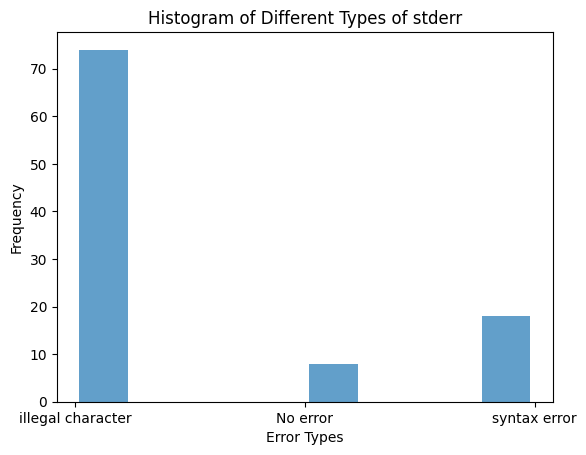

In [38]:


stderr_types = []
other_errors = []
no_errors = []
for run in runs:
    if run[1].stderr == "":
        no_errors.append(run)
        stderr_types.append("No error")
    elif "illegal character" in run[1].stderr:
        stderr_types.append("illegal character")
    elif "parse error" in run[1].stderr:
        stderr_types.append("parse error")
    elif "syntax error" in run[1].stderr:
        stderr_types.append("syntax error")
    else:
        other_errors.append(run)
        stderr_types.append("other")
        
# Plot histogram
plt.hist(stderr_types, bins='auto', alpha=0.7, rwidth=0.85)
plt.xlabel('Error Types')
plt.ylabel('Frequency')
plt.title('Histogram of Different Types of stderr')
plt.show()

We can see that (usually) no special types of error are found. Let's have a look though at some of the runs with no reported errors:

In [39]:
for run in no_errors:
    print(run)
    print('\n')

('#10!.#$!>=0<7\'&.2"* 4,9;2$?>*>#)?45$\'6: \'\'7<)5"(?-?7(!/2+:32;,35!40&2<!-', CompletedProcess(args='wsl bc', returncode=0, stdout='', stderr=''))


(';#(*"21?1:>6<54%612<:.??\'0;*!<;\'9\'0/7\'.\')/9#$*,)5+7\'#*-:.&<$. > /6\'#/3:8\'4:6:+=', CompletedProcess(args='wsl bc', returncode=0, stdout='', stderr=''))


('#', CompletedProcess(args='wsl bc', returncode=0, stdout='', stderr=''))


(';#8(<63.1+2', CompletedProcess(args='wsl bc', returncode=0, stdout='', stderr=''))


('737', CompletedProcess(args='wsl bc', returncode=0, stdout='737\n', stderr=''))


('.#8 ;57:&9+#0$5%8$*90,-6%*', CompletedProcess(args='wsl bc', returncode=0, stdout='0\n', stderr=''))


('#:', CompletedProcess(args='wsl bc', returncode=0, stdout='', stderr=''))


('', CompletedProcess(args='wsl bc', returncode=0, stdout='', stderr=''))


In one instance, for example, given the input `#2<%;./<,4<;9)==:*$*/>("$5")-7",,6$$,=+=-1<6$#0,>`, no errors were reported, and the output was empty (this can be tested above). 
In another instance, given the input `3##2;65%/ 2`, the program outputs `3`.
Whether this is desirable behaviour can be questioned.

Moreover, checking the return codes, all of them seem to be zero. This does suggest that even if it cannot provide an output, the output doesn't crash. This is a fix, as before, when the first fuzzers were found, the program was much less robust.

In [40]:
sum(1 for (data, result) in runs if result.returncode == 0)

100

## Bugs that can be found through fuzzing

### Error Handling
We will first define a class that allows exceptions to occur without stopping the entire execution of the program;

In [41]:
class ExpectError:
    """Execute a code block expecting (and catching) an error."""

    def __init__(self, exc_type: Optional[type] = None, 
                 print_traceback: bool = True, mute: bool = False):
        """
        Constructor. Expect an exception of type `exc_type` (`None`: any exception).
        If `print_traceback` is set (default), print a traceback to stderr.
        If `mute` is set (default: False), do not print anything.
        """
        self.print_traceback = print_traceback
        self.mute = mute
        self.expected_exc_type = exc_type

    def __enter__(self) -> Any:
        """Begin of `with` block"""
        return self

    def __exit__(self, exc_type: type, 
                 exc_value: BaseException, tb: TracebackType) -> Optional[bool]:
        """End of `with` block"""
        if exc_type is None:
            # No exception
            return

        if (self.expected_exc_type is not None
            and exc_type != self.expected_exc_type):
            raise  # Unexpected exception

        # An exception occurred
        if self.print_traceback:
            lines = ''.join(
                traceback.format_exception(exc_type,exc_value,tb)).strip()
        else:
            lines = traceback.format_exception_only(exc_type, exc_value)[-1].strip()

        if not self.mute:
            print(lines, "(expected)", file=sys.stderr)
        return True  # Ignore it

And now some example usage, with different parameter values:

In [42]:
# example usage
def fail_test() -> None:
    # Trigger an exception
    x = 1 / 0
with ExpectError():
    print("Run 1:")
    fail_test()
print("Reached the end!")

Run 1:
Reached the end!


Traceback (most recent call last):
  File "C:\Users\Cosmin\AppData\Local\Temp\ipykernel_23112\206402097.py", line 7, in <module>
    fail_test()
  File "C:\Users\Cosmin\AppData\Local\Temp\ipykernel_23112\206402097.py", line 4, in fail_test
    x = 1 / 0
ZeroDivisionError: division by zero (expected)


In [43]:
with ExpectError(mute = True):
    print("Run 2:")
    fail_test()
print("Reached the end!")

Run 2:
Reached the end!


In [44]:
with ExpectError(print_traceback = False):
    print("Run 3:")
    fail_test()
print("Reached the end!")

Run 3:
Reached the end!


ZeroDivisionError: division by zero (expected)


____________________
Now, let's also define a class that allows for programs to be interrupted after their execution time exceeds a certain threshold:

In [45]:
class GenericTimeout:
    """Execute a code block raising a timeout."""

    def __init__(self, timeout: Union[int, float]) -> None:
        """
        Constructor. Interrupt execution after `timeout` seconds.
        """

        self.seconds_before_timeout = timeout
        self.original_trace_function: Optional[Callable] = None
        self.end_time: Optional[float] = None

    def check_time(self, frame: FrameType, event: str, arg: Any) -> Callable:
        """Tracing function"""
        if self.original_trace_function is not None:
            self.original_trace_function(frame, event, arg)

        current_time = time.time()
        if self.end_time and current_time >= self.end_time:
            raise TimeoutError

        return self.check_time

    def __enter__(self) -> Any:
        """Begin of `with` block"""
        start_time = time.time()
        self.end_time = start_time + self.seconds_before_timeout

        self.original_trace_function = sys.gettrace()
        sys.settrace(self.check_time)
        return self

    def __exit__(self, exc_type: type, 
                 exc_value: BaseException, tb: TracebackType) -> Optional[bool]:
        """End of `with` block"""
        self.cancel()
        return None  # re-raise exception, if any

    def cancel(self) -> None:
        """Cancel timeout"""
        sys.settrace(self.original_trace_function)
    
class ExpectTimeout(GenericTimeout):
    """Execute a code block expecting (and catching) a timeout."""

    def __init__(self, timeout: Union[int, float],
                 print_traceback: bool = True, mute: bool = False):
        """
        Constructor. Interrupt execution after `seconds` seconds.
        If `print_traceback` is set (default), print a traceback to stderr.
        If `mute` is set (default: False), do not print anything.
        """
        super().__init__(timeout)

        self.print_traceback = print_traceback
        self.mute = mute

    def __exit__(self, exc_type: type,
                 exc_value: BaseException, tb: TracebackType) -> Optional[bool]:
        """End of `with` block"""

        super().__exit__(exc_type, exc_value, tb)

        if exc_type is None:
            return

        # An exception occurred
        if self.print_traceback:
            lines = ''.join(
                traceback.format_exception(exc_type,exc_value,tb)).strip()
        else:
            lines = traceback.format_exception_only(exc_type, exc_value)[-1].strip()

        if not self.mute:
            print(lines, "(expected)", file=sys.stderr)

        return True  # Ignore exception

Again, with an example usage (note that the same parameters as before can be used to define whether a traceback or the exception itself is printed):

In [46]:
def long_running_test() -> None:
    print("Start")
    for i in range(10):
        time.sleep(1)
        print(i+1, "seconds have passed")
    print("End")
    
with ExpectTimeout(5, print_traceback = False):
    long_running_test()

Start


KeyboardInterrupt (expected)


_________________________
### Using the tools
Now, we can easily simulate errors and how they can be caught in python:

#### Buffer Overflows

In [47]:
def crash_if_too_long(s):
    buffer = "Thursday"
    if len(s) > len(buffer):
        raise ValueError

trials = 100
with ExpectError(print_traceback = False):
    for i in range(trials):
        s = fuzzer()
        crash_if_too_long(s)

ValueError (expected)


#### Missing Error Checks
Consider the following code in C:
```c
while (getchar() != ' ');
```
If no space is present, then the program will keep on reading, since the C function getchar() returns a special `EOF` file when no more input is available.

In [48]:
def hang_if_no_space(s):
    i = 0
    while True:
        if i < len(s):
            if s[i] == ' ':
                break
        i += 1
        
trials = 100
with ExpectTimeout(2, print_traceback = False):
    for i in range(trials):
        s = fuzzer()
        hang_if_no_space(s)

TimeoutError (expected)


#### Rogue Numbers
Testing against unexpectedly large numbers:

In [49]:
def collapse_if_too_large(s):
    if int(s) > 1000:
        raise ValueError
long_number = fuzzer(100, ord('0'), 10)
with ExpectError(print_traceback = False):
    collapse_if_too_large(long_number)

ValueError (expected)


#### Information leaks
Accessing invalid memory locations can often lead to memory safety violations. To remedy this, address sanitizers (using fuzzing) can be run to test programs. However, leaks can also occur when valid addresses are accessed.

Take the following python code (replicating the HeartBleed bug, but memory spillage still occurs within regular array bounds ) :

In [50]:
secrets = ("<space for reply>" + fuzzer(100) +
           "<secret-certificate>" + fuzzer(100) +
           "<secret-key>" + fuzzer(100) + "<other-secrets>")

uninitialized_memory_marker = "deadbeef"
while len(secrets) < 2048:
    secrets += uninitialized_memory_marker
    
# type of service which would be used to check if a server is still running
def heartbeat(reply: str, length: int, memory: str) -> str:
    # Store reply in memory
    memory = reply + memory[len(reply):]

    # Send back heartbeat (essentially sends the first (length) characters from memory, which should theoretically contain the reply precisely
    s = ""
    for i in range(length):
        s += memory[i]
    return s

In [51]:
print(heartbeat("tomato", 6, memory=secrets))

tomato


In [52]:
# but if we specify a different length....
heartbeat("house", 66, memory=secrets)

'housee for reply>+(<>!>%%*2-==-?#>;:5>"?8\' 25%;!.4->%#;%4%&++<9#:9'

A potential fix would be to manually check that important information, nor uninitialized memory does not spill out:

In [53]:
with ExpectError():
    for i in range(10):
        s = heartbeat(fuzzer(), random.randint(1, 500), memory=secrets)
        assert not s.find(uninitialized_memory_marker)
with ExpectError():
    for i in range(10):
        s = heartbeat(fuzzer(), random.randint(1, 500), memory=secrets)
        assert not s.find("secret")

Traceback (most recent call last):
  File "C:\Users\Cosmin\AppData\Local\Temp\ipykernel_23112\2358597318.py", line 4, in <module>
    assert not s.find(uninitialized_memory_marker)
AssertionError (expected)
Traceback (most recent call last):
  File "C:\Users\Cosmin\AppData\Local\Temp\ipykernel_23112\2358597318.py", line 8, in <module>
    assert not s.find("secret")
AssertionError (expected)


In the previous code, a **static code checker** has also been used:
```python
def heartbeat(reply: str, length: int, memory: str) -> str: TODO
```
This insures that parameter types and the return string are right, as soon as types of arguments are properly declared.

In [54]:
with ExpectError(print_traceback = False):
    s = heartbeat("string", "notAnInt", "String") # note the highlighted warning

TypeError: 'str' object cannot be interpreted as an integer (expected)


## A fuzzing architecture
We are going to define some additional utility classes to simplify testing.

In [55]:
Outcome = str
class Runner:
    """Base class for testing inputs."""

    # Test outcomes
    PASS = "PASS"
    FAIL = "FAIL"
    UNRESOLVED = "UNRESOLVED"

    def __init__(self) -> None:
        """Initialize"""
        pass

    def run(self, inp: str) -> Any:
        """Run the runner with the given input"""
        return (inp, Runner.UNRESOLVED)
    
# ___ inheriting classes ___
class PrintRunner(Runner):
    """Simple runner, printing the input."""

    def run(self, inp) -> Any:
        """Print the given input"""
        print(inp)
        return (inp, Runner.UNRESOLVED)
    
class ProgramRunner(Runner):
    """Test a program with inputs."""
    program = ""

    def __init__(self, program: Union[str, List[str]]) -> None:
        """Initialize.
           `program` is a program spec as passed to `subprocess.run()`"""
        super().__init__()
        self.program = program

    def run_process(self, inp: str = "") -> subprocess.CompletedProcess:
        """Run the program with `inp` as input.
           Return result of `subprocess.run()`."""
        temp_result = subprocess.run(
            "wsl " + self.program, 
            input=(inp).encode(), 
            stdout=subprocess.PIPE,
            stderr=subprocess.PIPE)
        # decode the stdout and stderr for easier handling
        return CompletedProcess(
                     temp_result.args,
                     temp_result.returncode, 
                     temp_result.stdout.decode("utf-8"),
                     temp_result.stderr.decode("utf-8"))

    def run(self, inp: str = "") -> Tuple[subprocess.CompletedProcess, Outcome]:
        """Run the program with `inp` as input.  
           Return test outcome based on result of `subprocess.run()`."""
        result = self.run_process(inp)

        if result.returncode == 0:
            outcome = self.PASS
        elif result.returncode < 0:
            outcome = self.FAIL
        else:
            outcome = self.UNRESOLVED

        return (result, outcome)

Let's test our implementation with some basic function:

In [56]:
cat = ProgramRunner(program="cat")
cat.run("hello")

(CompletedProcess(args='wsl cat', returncode=0, stdout='hello', stderr=''),
 'PASS')

In [57]:
class Fuzzer:
    """Base class for fuzzers."""

    def __init__(self) -> None:
        """Constructor"""
        pass

    def fuzz(self) -> str:
        """Return fuzz input"""
        return ""

    def run(self, runner: Runner = Runner()) -> Tuple[subprocess.CompletedProcess, Outcome]:
        """Run `runner` with fuzz input"""
        return runner.run(self.fuzz())

    def runs(self, runner: Runner = PrintRunner(), trials: int = 10) -> List[Tuple[subprocess.CompletedProcess, Outcome]]:
        """Run `runner` with fuzz input, `trials` times"""
        return [self.run(runner) for i in range(trials)]
    
class RandomFuzzer(Fuzzer):
    """Produce random inputs."""

    def __init__(self, min_length: int = 10, max_length: int = 100, char_start: int = 32, char_range: int = 32) -> None:
        """Produce strings of `min_length` to `max_length` characters
           in the range [`char_start`, `char_start` + `char_range`)"""
        super().__init__()
        self.min_length = min_length
        self.max_length = max_length
        self.char_start = char_start
        self.char_range = char_range

    def fuzz(self) -> str:
        string_length = random.randrange(self.min_length, self.max_length + 1)
        out = ""
        for i in range(0, string_length):
            out += chr(random.randrange(self.char_start,
                                        self.char_start + self.char_range))
        return out

Of course, the `RandomFuzzer` can be used, as before, to generate random strings:

In [58]:
random_fuzzer = RandomFuzzer(min_length=20, max_length=20)
for i in range(10):
    print(random_fuzzer.fuzz())

3?&& =&117:&<?2"#$55
9626713%=&035>!)$5/'
,<82/><?)'7%.081$:&%
!0"2%:#/12&=5%<%35>+
2! !:=:#=?79#5&+;;-?
36 ?13=?43/03517%83*
4.:1,35 /#&>&"&)>!#"
'>051)((1-==5+7$,7;,
9.05!"03=91?:1=7"3)#
<-4#>4$=)-5,35#&">13


But, to simplify the process, one can directly run the fuzzer on the (predefined) program runner:

In [59]:
random_fuzzer.run(cat)

(CompletedProcess(args='wsl cat', returncode=0, stdout='&;=.&>:91-&),!* "62;', stderr=''),
 'PASS')

Or, to perform multiple runs:

In [60]:
random_fuzzer.runs(cat, 3)

[(CompletedProcess(args='wsl cat', returncode=0, stdout="<837'1=(-# 1)::'0-2?", stderr=''),
  'PASS'),
 (CompletedProcess(args='wsl cat', returncode=0, stdout='=<", ,9; 0?)+;3%=!1*', stderr=''),
  'PASS'),
 (CompletedProcess(args='wsl cat', returncode=0, stdout='<\'5*?5-7!94.\'*&4, 8"', stderr=''),
  'PASS')]

# Code Coverage
Testing can be divided into two categories, based on how we come up with the actual tests:
   - **Black-box** testing, where tests are derived from the specification
   - **White-box** testing, where tests are derived from the implementation
<br>

The latter actually are of interest when discussing coverage of structural features of the code.
There are numerous coverage metrics and there exists vast literature on different techniques that can be used to come up with test, achieving, for example, full branch / statement / MCDC coverage.

Yet, fuzzing can go beyond the limits of traditional testing, even if we don't check the correctness of our results against an _oracle_ (a pre-defined result checker).

To exemplify, we can use fuzzing to test some CGI-Decode function, which should turn `Hello%2c+world%21` into `Hello, world!`:


In [67]:
def cgi_decode(s: str) -> str:
    """Decode the CGI-encoded string `s`:
       * replace '+' by ' '
       * replace "%xx" by the character with hex number xx.
       Return the decoded string.  Raise `ValueError` for invalid inputs."""

    # Mapping of hex digits to their integer values
    hex_values = {
        '0': 0, '1': 1, '2': 2, '3': 3, '4': 4,
        '5': 5, '6': 6, '7': 7, '8': 8, '9': 9,
        'a': 10, 'b': 11, 'c': 12, 'd': 13, 'e': 14, 'f': 15,
        'A': 10, 'B': 11, 'C': 12, 'D': 13, 'E': 14, 'F': 15,
    }

    t = ""
    i = 0
    while i < len(s):
        c = s[i]
        if c == '+':
            t += ' '
        elif c == '%':
            digit_high, digit_low = s[i + 1], s[i + 2]
            i += 2
            if digit_high in hex_values and digit_low in hex_values:
                v = hex_values[digit_high] * 16 + hex_values[digit_low]
                t += chr(v)
            else:
                raise ValueError("Invalid encoding")
        else:
            t += c
        i += 1
    return t

We will run our test 100 times with the (random) inputs:

In [74]:

with ExpectError():
    for i in range(100):
        try:
            s = fuzzer()
            cgi_decode(s)
        except ValueError:
            pass

Traceback (most recent call last):
  File "C:\Users\Cosmin\AppData\Local\Temp\ipykernel_23112\99842176.py", line 5, in <module>
    cgi_decode(s)
  File "C:\Users\Cosmin\AppData\Local\Temp\ipykernel_23112\4072079982.py", line 22, in cgi_decode
    digit_high, digit_low = s[i + 1], s[i + 2]
IndexError: string index out of range (expected)


And, the code crashed! Let's check the input that caused this behaviour.

In [73]:
print(s)

.5/=+'=/,*45 =!>0260*5?%<


We have thus found a bug - after `%` two characters are expected, but this is not checked. Such an error can also be found in other implementations of our program, for example in C - potentially leading to some read out of bounds issue:
```c
int digit_high = *++s;
int digit_low = *++s;
```
What is particular in this case is that a strong test suite can be manually devised for this program, which achieves complete path / branch coverage, yet this bug can remain uncovered.

# Mutation-based fuzzing

When testing real-world programs, it is often needed to have inputs in a certain format, which, with the random fuzzer we currently have, would take years to produce strings in the right format (say, for a URL).

What might then help would be to start from a valid input, and randomy mutate it.

In [76]:
def delete_random_character(s: str) -> str:
    """Returns s with a random character deleted"""
    if s == "":
        return s

    pos = random.randint(0, len(s) - 1)
    # print("Deleting", repr(s[pos]), "at", pos)
    return s[:pos] + s[pos + 1:]

def insert_random_character(s: str) -> str:
    """Returns s with a random character inserted"""
    pos = random.randint(0, len(s))
    random_character = chr(random.randrange(32, 127))
    # print("Inserting", repr(random_character), "at", pos)
    return s[:pos] + random_character + s[pos:]

def flip_random_character(s):
    """Returns s with a random bit flipped in a random position"""
    if s == "":
        return s

    pos = random.randint(0, len(s) - 1)
    c = s[pos]
    bit = 1 << random.randint(0, 6)
    new_c = chr(ord(c) ^ bit)
    # print("Flipping", bit, "in", repr(c) + ", giving", repr(new_c))
    return s[:pos] + new_c + s[pos + 1:]

def mutate(s: str) -> str:
    """Return s with a random mutation applied"""
    mutators = [
        delete_random_character,
        insert_random_character,
        flip_random_character
    ]
    mutator = random.choice(mutators)
    # print(mutator)
    return mutator(s)

In [77]:
for i in range(10):
    print(repr(mutate("A quick brown fox")))

'A quick brownfox'
'A quick br own fox'
'A$quick brown fox'
'A quick brosn fox'
'A quicc brown fox'
'A uick brown fox'
'A quick broewn fox'
'A quick brgwn fox'
'A quick bDrown fox'
'A quick brownfox'


In [80]:
class MutationFuzzer(Fuzzer):
    """Base class for mutational fuzzing"""

    def __init__(self, seed: List[str], min_mutations: int = 2, max_mutations: int = 10) -> None:
        """Constructor.
        `seed` - a list of (input) strings to mutate.
        `min_mutations` - the minimum number of mutations to apply.
        `max_mutations` - the maximum number of mutations to apply.
        """
        super().__init__()
        self.seed_index = None
        self.population = None
        self.seed = seed
        self.min_mutations = min_mutations
        self.max_mutations = max_mutations
        self.reset()

    def reset(self) -> None:
        """Set population to initial seed.
        To be overloaded in subclasses."""
        self.population = self.seed
        self.seed_index = 0
        
    def delete_random_character(s: str) -> str:
        """Returns s with a random character deleted"""
        if s == "":
            return s
    
        pos = random.randint(0, len(s) - 1)
        # print("Deleting", repr(s[pos]), "at", pos)
        return s[:pos] + s[pos + 1:]
    
    def insert_random_character(s: str) -> str:
        """Returns s with a random character inserted"""
        pos = random.randint(0, len(s))
        random_character = chr(random.randrange(32, 127))
        # print("Inserting", repr(random_character), "at", pos)
        return s[:pos] + random_character + s[pos:]
    
    def flip_random_character(s):
        """Returns s with a random bit flipped in a random position"""
        if s == "":
            return s
    
        pos = random.randint(0, len(s) - 1)
        c = s[pos]
        bit = 1 << random.randint(0, 6)
        new_c = chr(ord(c) ^ bit)
        # print("Flipping", bit, "in", repr(c) + ", giving", repr(new_c))
        return s[:pos] + new_c + s[pos + 1:]
    
    def mutate(self, s: str) -> str:
        """Return s with a random mutation applied"""
        mutators = [
            delete_random_character,
            insert_random_character,
            flip_random_character
        ]
        mutator = random.choice(mutators)
        # print(mutator)
        return mutator(s)
    
    def create_candidate(self) -> str:
        """Create a new candidate by mutating a population member"""
        candidate = random.choice(self.population)
        trials = random.randint(self.min_mutations, self.max_mutations)
        for i in range(trials):
            candidate = self.mutate(candidate)
        return candidate

    def fuzz(self) -> str:
        if self.seed_index < len(self.seed):
            # Still seeding
            self.inp = self.seed[self.seed_index]
            self.seed_index += 1
        else:
            # Mutating
            self.inp = self.create_candidate()
        return self.inp

In [85]:
seed_input = "http://www.google.com/search?q=fuzzing"
mutation_fuzzer = MutationFuzzer(seed=[seed_input])
for i in range(20):
    print(mutation_fuzzer.fuzz())
    

http://www.google.com/search?q=fuzzing
http:?/www.google.coMm/search?q5fuzz2ing
http/wMww.oogle.com/search?q=fuzzinw
httpw://www.g6oglecmm/search?q=fuzpzie
http://www.oooYgle.comosear8ch?q5fuz~ing
ht//www.google.com/earcqhq=fu~zing
http:/ww/w.goo6gle.c/serch?q=fuzzing
htt|p://www.googlecom/search?q=fuzzing
lttp://www.gocJogle.cm/searcH?q=fuzzng
htTp://www.g'oogle.omN/searUch?Kq=fuzzing
http://www>google.com/search?q=fuzzinH
http://wwgoogle.com/search~?qFN=fuz(zing
http://www.gogle.coM/sarch?q=fuzzhng
http:b//www,g_ooolm.cm/1earch?q=fuzzing
xhttp://w7.googlew.com/search?q=fuzzing
http://www.google.comq/search?q}duzzing
http://wwwgoQogle.com/search?q=fuz$zing
http://www.googhe.com/search?q=fuFzzing
htt9p://ww&gkog=h.coVm/search?q=fuzziNg
htt#p:'/ww.mogl.com/seakrch?q=fuzzi.g


## Guiding by Coverage

Now that we have the basis - a fuzzer that can produce random input, and a mutator that can (randomly) alter existing input, one can go further to **guide** our fuzzing _journey_ by coverage, without taking the specification of a program into consideration, rather leveraging its **structure**.

A basic but important idea is that we can keep (and _evolve_) test cases which lead to discovering a new path (reaching new lines) in the program's execution. Implementing this idea for the above url decoder will lead to the following **evolution** of our test set (also called _population_):

In [8]:
reference = 'http://www.google.com/search?q=fuzzing'

output = ['http://www.google.com/search?q=fuzzing',
 'http://www.goog.com/search;q=fuzzilng',
 'http://ww.6goog\x0eoomosearch;/q=f}zzilng',
 'http://uv.Lboo.comoseakrch;q=fuzilng',
 'http://ww.6goog\x0eo/mosarch;/q=f}z{il~g',
 'http://www.googme.com/sear#h?q=fuzzing',
 'http://www.oogcom/sa3rchq=fuzlnv|',
 'http://ww.6goog*./mosarch;/q=f}Zz{ilel~g',
 'http://uv.Lboo.comoseakch;q=fuzilng',
 'http://www.goom^e.2com/s?ear#h?q=fuzzing',
 'http://hwww.coole.com+search?R=fuzzig',
 'http://ww.6g7oog*./mosarch; #/q;f}Zz{ilel~gL',
 "http://ww.6'oog*R./mosarcx;/q=}Zz{ilel;~g",
 'http://www.goofme.com/sear#h?q=fuzzi*yng',
 "http://sw.6'oog*R/msa'rcx;/qw?}Zz{ileRl;~g",
 "http://sw.6'oog*R/msa'rsx;/qw?}Zz{ileRUl;~g",
 "http://sw.6'oog*R/msa'rsx;qw?}Zz{ileRU;~g",
 'http://wgw.gooBm^e.2com/s?&eir#h?q=]fuzzing',
 "http://sw.6'ooM*R/mDa'rsx;w?}Zz{ileU+~g",
 "http://sw.6L'ooM*R/mKD'rwx;w?}Z~{ileU#zg",
 'http://ww6g7ooVg:./mosarc; #/q;f}ZzF{ielW~gL',
 "http://Jsw.6L'oM*R/mKD'r3w;w?~{ileU#zg",
 "http://sw.6'oog*R/msa'rsx;/qw?}Z#z{ileRYUl;~g",
 "http://sw6'oog*V/msa'rsx;/w\x7f}Z#zileRUl;~g",
 "http://sw6'oog*/msa'rsx;/g\x7fp}Z#zileRUl;~g"]

Note how most / all of these are valid URLs, our previous set of randomly mutated URLs. We can now plot the Edit distance (smallest number of edit operations required to transform one string into the other) from the original input to each of the newly generated inputs.

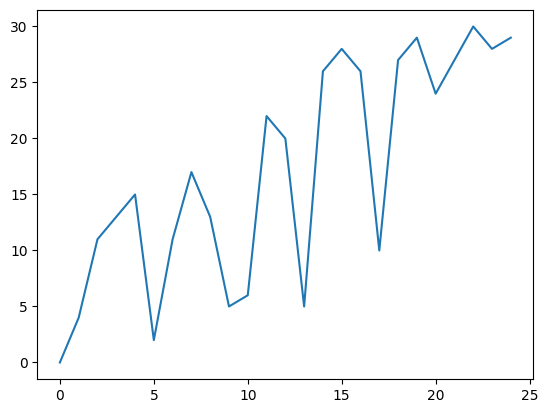

In [13]:
def minDis(s1, s2, n, m, dp):
 
    # If any string is empty,
    # return the remaining characters of other string
    if(n == 0):
        return m
    if(m == 0):
        return n
 
    # To check if the recursive tree
    # for given n & m has already been executed
    if(dp[n][m] != -1):
        return dp[n][m]
 
    # If characters are equal, execute
    # recursive function for n-1, m-1
    if(s1[n - 1] == s2[m - 1]):
        if(dp[n - 1][m - 1] == -1):
            dp[n][m] = minDis(s1, s2, n - 1, m - 1, dp)
            return dp[n][m]
        else:
            dp[n][m] = dp[n - 1][m - 1]
            return dp[n][m]
 
    # If characters are nt equal, we need to
    # find the minimum cost out of all 3 operations.
    else:
        if(dp[n - 1][m] != -1):
            m1 = dp[n - 1][m]
        else:
            m1 = minDis(s1, s2, n - 1, m, dp)
 
        if(dp[n][m - 1] != -1):
            m2 = dp[n][m - 1]
        else:
            m2 = minDis(s1, s2, n, m - 1, dp)
        if(dp[n - 1][m - 1] != -1):
            m3 = dp[n - 1][m - 1]
        else:
            m3 = minDis(s1, s2, n - 1, m - 1, dp)
 
        dp[n][m] = 1 + min(m1, min(m2, m3))
        return dp[n][m]
 
 
distances = []
for result in output:
    str1 = result
    str2 = reference
    n = len(str1)
    m = len(str2)
    dp = [[-1 for i in range(m + 1)] for j in range(n + 1)]
    distances.append(minDis(result, reference, len(result), len(reference), dp))
    
plt.plot(distances)

We can see that generally the distance seems increasing, but the trend isn't strictly increasing, sometimes getting closer, again, to the original input string.

### American fuzzy lop (AFL) 

The above concept is successfully exploited in the AFL testing tool. Choosing the methods by which input is fuzzed is a problem of optimization. Processing time can be "measured" by the number of actual executions of the program (made thorough the linux systemcall `execve`) - and it is easy to waste:
- If changes are too **conservative**, the fuzzer will likely not improve much in coverage
- If they are too **aggressive**, inputs will fail parsing early, leading to a limitation in the exploration of new paths

Thus, coming up with fuzzing mutation engine is a major challenge. Empirically, the efficiency of various methods has been tested, here being a few of the most notable techniques:
- **Walking bit flips**
    Performing sequential, ordered, for a varying number of bits:
    - 1 : 70 new paths per one million generated inputs
    - 2 : 20 new paths per one million generated inputs
    - 4 : 10 new paths.. (clearly, returns are rapidly diminishing)
- **Walking byte flips**
    One might notice that, naturally, 8 executions are needed for each byte of input. This can be reduced to 1, simply changing the implementation to alter sequences of 1, 2 or 3 bytes (with constant stepover of one byte) => 30 additional paths per million inputs
- **Arithmetics**
    To trigger more complex conditions, one can deterministically look at integer values in the input file. Interestingly, a range of `-35 to +35` yields the most significant results - approach with differs from a standard tactic of trying each value for a byte, for a range of `-128 to +127`
    - In practice, integers can also be replaced by common edge triggering values (e.g. `-1, 256, 1024, MAX_INT-1, MAX_INT`)
- **Stacked tweaks**
    Randomized operations can be combined (e.g. 1 to 64 operations, block size capped to 1 kB), as, experimentally, these all seem to be contributing similarly to the extension of coverage:
    - Single-bit flips,
    - Particular bytes, words, or dwords (both endians)
    - Addition or subtraction of small integers to bytes, words, or dwords (both endians)
    - Completely random single-byte sets
    - Block deletion
    - Block duplication via overwrite or insertion
    - Block memset
- **Test case splicing**
    Provided that a varied population of input files exits from the start, one can also combine two of them, then run this output through some stacked tweaks, resulting around 20% additional execution paths. Note that, inherent from the concept of creating pairs of input files, this often has quadratic runtime.

# Search based fuzzing
When we want to reach a certain target (e.g. a specific statement), we can see **test generation as a search problem**. Thus, the *search space* will be defined by the type and format of inputs of the program under question. One specific input would also have some *neighbours*, defined by how individuals are related to each other.

### Defining fitness
Then, we need a **fitness** function gives a quantification of how close any point in the search space is to being an optimal solution.

For example, consider the following program:
```python
def test_me(x, y):
    if x == 2 * (y + 1):
        return True
    else:
        return False
```
If we set our goal to reach the `return True` line, then we can use as a fitness function just how different the two terms are. (Implementation wise, one can create an instrumented program version, where the distance is calculated as the update of a global variable, then retrieved in some other `get_fitness(input)` function).

### Hill climbing
A natural algorithm arises for finding the optimal input:
1. Take a random starting point
2. Determine fitness value of all neighbors
3. Move to neighbor with the best fitness value (A common pitfall is that such an algorithm will get stuck in local optimum, thus, if no better neighbour is find, but we have not reached an optimal solution (fitness/distance 0), then we randomly restart)
4. If solution is not found, continue with step 2

### String inputs
We can consider neighbours with an edit distance of 1 as the *neighbours* of a point.

...

# GreyBox Fuzzing
This type of fuzzing is the border between white and black fuzzing. Class arguments: seed input, mutator, power schedule. The power schedule is used to distribute the fuzzing effort across the population. Apart from the basci one, there exist 2 advanced schedules: AFLFastSchedule-> assigns energy to "unusual " paths.
AFLGoSchedule -> assigns high energy to paths close to uncovered program locations.


### Fuzzing with Grammars
A grammar consists of an expression, and it is used to specify a language (= a set of valid inputs). It is made of rules.
The process consists of randomly choosing expansions of a symbol and it stops when all nonterminal symbols are extended.

They are of great use when it comes to Turing machines.

  
Arithmetic expressions consist of a start term, an expression( which is a sum, a difference or a term), a term is a product, a division or a factor; a factor is a number or a paranthesized expression.

Example:

 \<start\>   ::= \<expr\>
\<expr\>    ::= \<term\> + \<expr\> | \<term\> - \<expr\> | \<term\>
\<term\>    ::= \<term\> * \<factor\> | \<term\> / \<factor\> | \<factor\>
\<factor\>  ::= +\<factor\> | -\<factor\> | (\<expr\>) | \<integer\> | \<integer\>.\<integer\>
\<integer\> ::= \<digit\>\<integer\> | \<digit\>
\<digit\>   ::= 0 | 1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 | 9 
 


Each symbol ( a string) is mapped to a list of expansions ( strings).

It is a language based fuzzer. You can manually add probabilities and inputs that you want to encounter often.
This fuzzing method has its limitations. What we can do is to make grammar-generated inputs seeds for mutation-based fuzzing.
We also have to make sure that our grammar rules are consistent, and thus we can introduce a helper function.



### Efficient Grammar Fuzzing

### Derivation Trees 
- represent the set of derivations that we undertake when we produce a string, such that every symbol is extended until we don't encounter any nonterminal symbols anymore. The tree is traversed in a postorder manner.

In this way, we can take a non-explanded node in the tree, choose a random expression and then return the new tree.



